In [152]:
import os

import editdistance
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch
import torch.nn.functional as F
from speechbrain.inference import SpeakerRecognition
from torch import optim, nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer
from transformers import pipeline
## IMPORTS ##


In [153]:
np.random.seed(42)
torch.manual_seed(42)

## SEED ##


In [154]:
def parse_line(line):
    parts = line.strip().split("|")
    if len(parts) < 2:
        return None, None
    return parts[0], parts[1]


class Dataset(Dataset):
    def __init__(self, data_folder, metadata_path, tokenizer, n_mels=80, max_mel_len=32, max_text_len=16, max_samples=500):
        self.data_folder = data_folder
        self.tokenizer = tokenizer
        self.n_mels = n_mels
        self.max_mel_len = max_mel_len
        self.max_text_len = max_text_len
        self.items = self._load_metadata(metadata_path, max_samples)

    def _load_metadata(self, metadata_path, max_samples):
        items = []
        with open(metadata_path, encoding='utf-8') as f:
            for i, line in enumerate(f):
                audio_file, text = parse_line(line)
                if not audio_file or not text:
                    continue
                wav_path = os.path.join(self.data_folder, audio_file + ".wav")
                if os.path.exists(wav_path):
                    items.append((wav_path, text))
                if len(items) >= max_samples:
                    break
        return items

    def _load_and_process_audio(self, wav_path):
        y, sr = librosa.load(wav_path, sr=22050)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels, hop_length=256)
        mel = librosa.power_to_db(mel).astype(np.float32)
        return self._pad_or_trim_mel(mel)

    def _pad_or_trim_mel(self, mel):
        if mel.shape[1] < self.max_mel_len:
            pad_width = self.max_mel_len - mel.shape[1]
            mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel = mel[:, :self.max_mel_len]
        return mel.T

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        wav_path, text = self.items[idx]
        mel = self._load_and_process_audio(wav_path)
        tokenized = self._tokenize_text(text)
        return {
            "input_ids": tokenized.input_ids.squeeze(0),
            "attention_mask": tokenized.attention_mask.squeeze(0),
            "mel": torch.tensor(mel, dtype=torch.float32)
        }

    def _tokenize_text(self, text):
        return self.tokenizer(
            text,
            return_tensors="pt",
            padding='max_length',
            max_length=self.max_text_len,
            truncation=True
        )

In [155]:
class Model(nn.Module):
    def __init__(self, out_dim=80):
        super().__init__()
        self._initialize_model(out_dim)

    def _initialize_model(self, out_dim):
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        self.out_proj = nn.Linear(self.gpt2.config.n_embd, out_dim)

    def forward(self, input_ids, attention_mask=None):
        hidden = self._extract_hidden_states(input_ids, attention_mask)
        return self._project_to_mel(hidden)

    def _extract_hidden_states(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return outputs.hidden_states[-1]

    def _project_to_mel(self, hidden_states):
        return self.out_proj(hidden_states)

In [156]:
asr = pipeline("automatic-speech-recognition", model="openai/whisper-tiny")

Device set to use cuda:0


In [157]:

def fit_model(net, dataloader, opt, loss_fn, device, num_epochs):
    net.train()
    total_steps = len(dataloader)

    for ep in range(num_epochs):
        running_loss = 0
        print(f"🌍 Epoch [{ep + 1}/{num_epochs}]")

        for idx, batch in enumerate(dataloader):
            ids, masks, targets = (batch[k].to(device) for k in ["input_ids", "attention_mask", "mel"])

            out = net(ids, masks)

            out = F.interpolate(out.permute(0, 2, 1), size=targets.shape[1], mode="nearest").permute(0, 2, 1)

            loss = loss_fn(out, targets)
            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item()
            if (idx + 1) % 50 == 0:
                print(f"    ⌛ Batch {idx + 1}/{total_steps} - Batch Loss: {loss.item():.4f}")

        avg_loss = running_loss / total_steps
        print(f"✅ Finished Epoch {ep + 1} - Average Loss: {avg_loss:.4f}\n")


In [158]:
def tokenize_text_input(tokenizer, text: str, device: str, max_len: int):
    encoded = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len)
    return encoded.input_ids.to(device), encoded.attention_mask.to(device)


def pad_mel_to_length(mel: np.ndarray, target_len: int) -> np.ndarray:
    if mel.shape[1] < target_len:
        return np.pad(mel, ((0, 0), (0, target_len - mel.shape[1])), mode='constant')
    return mel[:, :target_len]


def predict_mel_spectrogram(model, tokenizer, text: str, device: str, max_len: int = 32) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        input_ids, attn_mask = tokenize_text_input(tokenizer, text, device, max_len)
        mel = model(input_ids, attn_mask)[0].cpu().numpy().T
        return pad_mel_to_length(mel, max_len)


def synthesize_audio_from_mel(mel_db: np.ndarray, sr: int = 22050) -> np.ndarray:
    mel_power = librosa.db_to_power(mel_db)
    return librosa.feature.inverse.mel_to_audio(mel_power, sr=sr, n_fft=1024, hop_length=256)


def transcribe_waveform(signal: np.ndarray, rate: int = 22050, fname="tmp_audio.wav") -> str:
    sf.write(fname, signal, rate)
    return asr(fname)['text'].strip()


def normalize_text_for_cer(text: str) -> str:
    return text.replace(" ", "").lower()


def string_distance_metric(predicted: str, target: str) -> float:
    pred_clean = normalize_text_for_cer(predicted)
    tgt_clean = normalize_text_for_cer(target)
    return editdistance.eval(pred_clean, tgt_clean) / max(len(tgt_clean), 1)


In [159]:
def display_mel_spectrogram(mel_matrix, title="Mel Spectrogram"):
    plt.figure(figsize=(9, 3.5))
    heatmap = plt.imshow(mel_matrix, interpolation="nearest", origin="lower", aspect="auto")
    plt.title(title, fontsize=12)
    plt.xlabel("Time Steps")
    plt.ylabel("Frequency Channels")
    cbar = plt.colorbar(heatmap, pad=0.02)
    cbar.ax.set_ylabel('dB', rotation=270, labelpad=10)
    plt.tight_layout(pad=1.5)
    plt.grid(False)
    plt.show()


In [160]:
class Config:
    DATA_FOLDER = "LJSpeech/LJSpeech-1.1/wavs"
    METADATA_PATH = "LJSpeech/LJSpeech-1.1/metadata.csv"
    BATCH_SIZE = 4
    EPOCHS = 30
    LR = 5e-5
    N_MELS = 80
    MAX_MEL_LEN = 32
    MAX_TEXT_LEN = 16
    MAX_SAMPLES = 500
    DEVICE = torch.device("cuda")

In [161]:
class CustomTokenizer:
    def __init__(self, base):
        self.tokenizer = base

    def add_pad_if_missing(self):
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        return self

    def build(self):
        return self.tokenizer

tokenizer = CustomTokenizer(GPT2Tokenizer.from_pretrained("gpt2")).add_pad_if_missing().build()

In [162]:
def prepare_loader(config, tokenizer):
    dataset = Dataset(
        config.DATA_FOLDER,
        config.METADATA_PATH,
        tokenizer,
        n_mels=config.N_MELS,
        max_mel_len=config.MAX_MEL_LEN,
        max_text_len=config.MAX_TEXT_LEN,
        max_samples=config.MAX_SAMPLES
    )
    return DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True)


def prepare_model(config, tokenizer):
    model = Model(out_dim=config.N_MELS).to(config.DEVICE)
    model.gpt2.resize_token_embeddings(len(tokenizer))
    return model

In [163]:
speech_loader = prepare_loader(Config, tokenizer)
acoustic_model = prepare_model(Config, tokenizer)
optim_engine = optim.AdamW(acoustic_model.parameters(), lr=Config.LR)
loss_metric = nn.MSELoss()

fit_model(acoustic_model, speech_loader, optim_engine, loss_metric, Config.DEVICE, Config.EPOCHS)


🌍 Epoch [1/30]
    ⌛ Batch 50/125 - Batch Loss: 497.4307
    ⌛ Batch 100/125 - Batch Loss: 392.6770
✅ Finished Epoch 1 - Average Loss: 510.3303

🌍 Epoch [2/30]
    ⌛ Batch 50/125 - Batch Loss: 291.9357
    ⌛ Batch 100/125 - Batch Loss: 209.1880
✅ Finished Epoch 2 - Average Loss: 281.3406

🌍 Epoch [3/30]
    ⌛ Batch 50/125 - Batch Loss: 238.1056
    ⌛ Batch 100/125 - Batch Loss: 169.5073
✅ Finished Epoch 3 - Average Loss: 209.7423

🌍 Epoch [4/30]
    ⌛ Batch 50/125 - Batch Loss: 189.0710
    ⌛ Batch 100/125 - Batch Loss: 183.0203
✅ Finished Epoch 4 - Average Loss: 189.2136

🌍 Epoch [5/30]
    ⌛ Batch 50/125 - Batch Loss: 192.2150
    ⌛ Batch 100/125 - Batch Loss: 161.5286
✅ Finished Epoch 5 - Average Loss: 183.8675

🌍 Epoch [6/30]
    ⌛ Batch 50/125 - Batch Loss: 198.5257
    ⌛ Batch 100/125 - Batch Loss: 162.0513
✅ Finished Epoch 6 - Average Loss: 177.9564

🌍 Epoch [7/30]
    ⌛ Batch 50/125 - Batch Loss: 195.7714
    ⌛ Batch 100/125 - Batch Loss: 157.5592
✅ Finished Epoch 7 - Average L

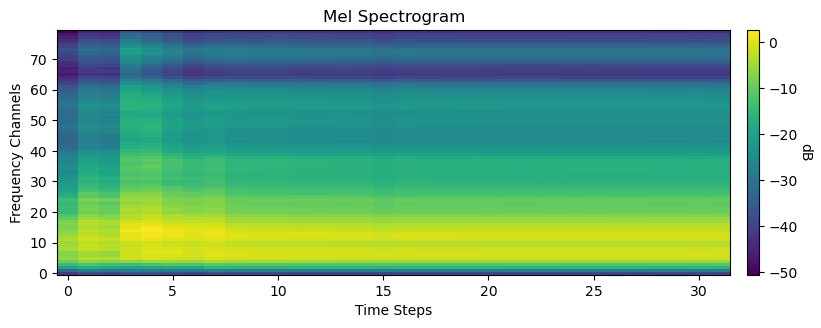

🎯 Expected : Artificial intelligence is transforming the world.
🗣️ Transcribed : you
📉 CER: 0.9778
------------------------------------------------------------


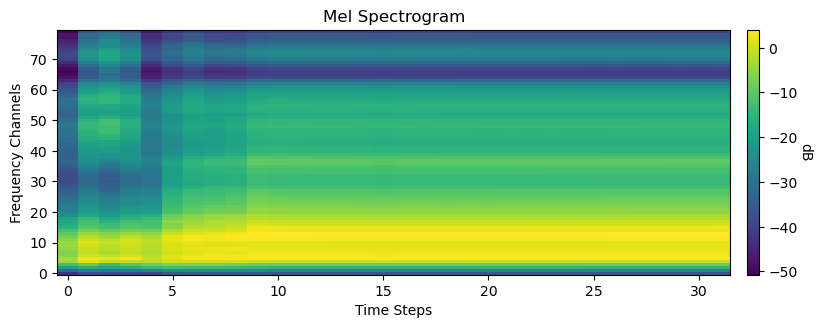

🎯 Expected : The quick brown fox jumps over the lazy dog.
🗣️ Transcribed : Thank you.
📉 CER: 0.8333
------------------------------------------------------------


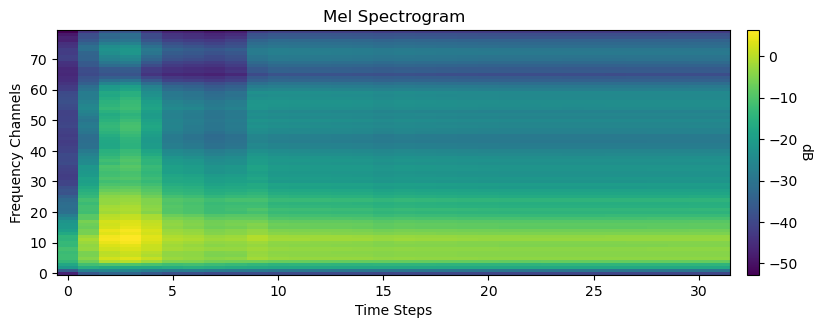

🎯 Expected : Voice synthesis is an exciting field in deep learning.
🗣️ Transcribed : you
📉 CER: 0.9783
------------------------------------------------------------


In [164]:
samples_for_demo = [
    "Artificial intelligence is transforming the world.",
    "The quick brown fox jumps over the lazy dog.",
    "Voice synthesis is an exciting field in deep learning."
]

speaker_encoder = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb"
)

for original_text in samples_for_demo:
    mel_spec = predict_mel_spectrogram(acoustic_model, tokenizer, original_text, Config.DEVICE)
    display_mel_spectrogram(mel_spec)

    synthetic_wave = synthesize_audio_from_mel(mel_spec)
    transcription = transcribe_waveform(synthetic_wave)
    distance = string_distance_metric(transcription.lower(), original_text.lower())

    print(f"🎯 Expected : {original_text}")
    print(f"🗣️ Transcribed : {transcription}")
    print(f"📉 CER: {distance:.4f}")
    print("-" * 60)
